# Sentiment Analysis
***
Sentiment Analysis is a field within Natural Language Processing (NLP) that builds systems that try to identify and extract opinions within text. So it tries to determine whether a piece of text is positive, neutral or negative and this is done through the use of variables such as context , tone and emotion.


# Sentiment Analysis using the Twitter dataset
***
Through out this tutorial we are going to try and classify tweets into positive or negative sentiment based on their content.

### Getting started
To get started we need to import some important modules to help us:

1. Keras  -  A high-level neural networks API, written in Python.

2. Matplotlib - 2D plotting library.

3. Pandas - library providing high-performance, easy-to-use data structures and data analysis tools.

4. Seaborn  - module implements a fundamental, but powerful algorithm for serializing and de-serializing a Python object structure.

5. SkLearn - Simple and efficient tools for data mining and data analysis




In [1]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Activation, Flatten, SpatialDropout1D
from keras.optimizers import SGD

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer

import seaborn as sns
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

Using TensorFlow backend.


### Load and Clean the Data
Load the data(train.csv) as before with pandas and take a look at the data so we know what we will be working with.

To Do:

- Load the dataset into a dataframe with pandas
- Clean the data so it is easier to work with.

In [3]:
#load the train.csv file to a dataframe
tweets = pd.read_csv('https://ai-camp-content.s3.amazonaws.com/train.csv', ',', encoding='ISO-8859-1')

#Display the first 5 rows of the dataframe
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [5]:
#View the shape of the dataframe
tweets.shape

(99989, 3)

In [0]:
#clean up the tweets

#Make the text lowercase
tweets['SentimentText'] = tweets['SentimentText'].apply(lambda x: x.lower())

#Replace any special characters
tweets['SentimentText'] = tweets['SentimentText'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

In [7]:
tweets.head(5)

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my apl friend
1,2,0,i missed the new moon trailer
2,3,1,omg its already 730 o
3,4,0,omgaga im sooo im gunna cry ive be...
4,5,0,i think mi bf is cheating on me ...


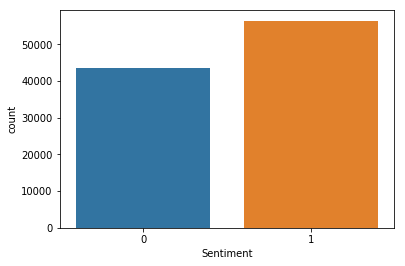

In [9]:
#Plot the sentiment on a graph using sns
tweets['Sentiment'].value_counts()
sns.countplot(tweets['Sentiment'])

### Tokenise
We are going to use tokenisation to find the 2000 most common words. 

A token is an instance of a sequence of characters. A type is the class of all tokens containing the same character sequence.

To Do:

- Define the max features
- Initialise a tokeniser with the max feature and a defined split
- Calculate the different word frequencies
- Add padding to the sequences


Replace the "..." in the following code to make it run!

In [11]:
#tokenisation

max_features = 2000

#create a tokenizer that takes the 2000 most common words and Separator for word splitting.
tokenizer = Tokenizer(num_words=max_features , split=' ') #The space is the separator 

#calculate the frequency of each word in the dataset - fit_on_texts creates the vocabulary index based on word frequency. Every word gets its a unique innteger value and 0 is reserved for padding.
tokenizer.fit_on_texts(tweets['SentimentText'].values)

#text_to-sequence basically takes each word in the text and replaces it with its corresponding integer value.
X = tokenizer.texts_to_sequences(tweets['SentimentText'].values)

#applying padding as the NN needs samples that are the same size
X = pad_sequences(X)
print(X[:1])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0  10  18 123   9   8 266]]


## Build the Model
As before define and build the model you want to train with this dataset.

To Do:

- Define a sequential model and add your layers.
- Compile the model
- (Optional) Display the layers with summary()



Replace the "..." in the following code to make it run!

In [35]:
#larger lstm dropout + lstm_out = embed_dim + extra layers.
#Note that embed_dim and lstm_out are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. 
embed_dim = 128
lstm_out = 196


#A Sequential model is a linear stack of layers. Intialise an empty sequential model to add layers to 
model = Sequential()

#embedding layer lets the network expand each token into a larger vector
#Fill in the following parameters: 1. size of our vocabulary, 2. embedding dimesion(embed_dim) - expands to a vector of 128 3. length of input
model.add(Embedding(max_features, embed_dim,  input_length = X.shape[1]))

#SpatialDropout1D takes a paramter of a float between 0 and 1. The fraction of the input units to drop.
model.add(SpatialDropout1D(0.1))

#CNN layer gives a higher view of the sequences to the LSTM example: "I loved this friendly service"
#could be processed as "I love this" "Friendly service" which is two chunks for the LSTM rather than 5 chunks


#1. the size of our word embeddings, 2&3. dropouts - resetting a random amount of weights (make it harder for the 
#NN to learn patterns)
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))


#Dense is a regular densely-connected NN layer, it takes in units which is a positive integer, dimensionality of the output space and the Activation function to use.
model.add(Dense(128, activation="tanh"))
model.add(Dense(2, activation="softmax"))

# compiles the model using backend library (tensorflow), using categorical becuase our targets are one-hot encoded.
#adam is an algorithm for first-order gradient-based optimization
#metrics is a list of metrics to be evaluated by the model during training and testing
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 84, 128)           256000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 84, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               25216     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 258       
Total params: 536,274
Trainable params: 536,274
Non-trainable params: 0
_________________________________________________________________
None


## Split the Data and Train

Again we need to split the data so we have testing data and validation data to work with. The easiest way to do this is to make use of the scikit-learn library's function train_test_split.

To Do:

- Train the model with the data you have just organised
- Make predictions 

Replace the "..." in the following code to make it run

In [38]:
#get_dummies converts categorical variables into dunny/indicator variables
Y  = pd.get_dummies(tweets['Sentiment']).values

#Use train_test_split to split arrays or matrices into random train and test subsets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

#Print out the shape for X and Y both train and test
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(79991, 84) (19998, 84) (79991, 2) (19998, 2)


In [40]:
# The batch size defines the number of samples that will be propagated through the network.
batch_size  = 500

#Model.fit - Trains the model for a given number of iterations on a dataset.
#Parameters - (X and y train, batch_size, iterations, validation data(e.g. X and Y test))
model.fit(x_train, 
          y_train, 
          batch_size=batch_size,
          epochs = 5,
          validation_data=(x_test, y_test))

Train on 79991 samples, validate on 19998 samples
Epoch 1/5
79991/79991 [==============================] - 42s 524us/step - loss: 0.5017 - acc: 0.7552 - val_loss: 0.5041 - val_acc: 0.7559
Epoch 2/5
79991/79991 [==============================] - 42s 522us/step - loss: 0.4815 - acc: 0.7677 - val_loss: 0.4961 - val_acc: 0.7613
Epoch 3/5
79991/79991 [==============================] - 42s 521us/step - loss: 0.4697 - acc: 0.7725 - val_loss: 0.4904 - val_acc: 0.7627
Epoch 4/5
79991/79991 [==============================] - 42s 522us/step - loss: 0.4609 - acc: 0.7793 - val_loss: 0.4895 - val_acc: 0.7631
Epoch 5/5
79991/79991 [==============================] - 42s 522us/step - loss: 0.4521 - acc: 0.7829 - val_loss: 0.4866 - val_acc: 0.7628


In [0]:
#Make predictions
predictions = model.predict_classes(x_test)

In [23]:
predictions

array([1, 0, 1, ..., 1, 1, 0])

In [0]:
#convert the tokenized sequences of X test, back into text to display it
X_text = tokenizer.sequences_to_texts(x_test)

In [27]:
#Display predictions along side tweets
d = {'Prediction': predictions, 'Tweet': X_text}
df = pd.DataFrame(d)
pd.set_option('max_colwidth', 1300)
display(df.head(10))

,Prediction,Tweet
0,1,bass you never say that to me
1,0,amp me made me and i was so sad
2,1,
3,0,i do dogs around and cats too something about me and
4,1,ashleytisdale please follow me im following you
5,0,amp c a none worked my poor are now
6,1,head all well
7,1,to v word a live u ma to
8,0,hope the weather has
9,1,my new for review today that was fast me and happy thanks


In [41]:
#Show the accuracy
score, accuracy = model.evaluate(x_test, y_test)

print('Test Score', score)
print('Test accuracy:', accuracy)


19998/19998 [==============================] - 45s 2ms/step
Test Score 0.4865673397741195
Test accuracy: 0.7627762776396849


## Exercises

1. Try to impove the models accuracy 
 
 Hint:
    - Try changing things like embed_dim, lstm_out, epochs and dropout
      
      
      

# Stretch Exercise:

In the above tutorial we created our model using Keras - For this exercise, we would like you to complete the same challenge but use the SKLearn SDGClassifier instead. 

The goal of this exercise is to show you ways of doing the same thing using different libraries.

## Split the Data and Train
The twitter dataset should already be cleaned from above - so we can go straight to spliting it up using the scikit-learn library's function train_test_split.

In [48]:
#Use train_test_split to split arrays or matrices into random train and test subsets
x_train, x_test, y_train, y_test = train_test_split(tweets['SentimentText'], tweets['Sentiment'], test_size = 0.2)

#Print out the shape for X and Y both train and test
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#Print out the first 10 values in Y
print(Y[:10])

(79991,) (19998,) (79991,) (19998,)
[[1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]


## Count Vectorizer

Previously in the tutorial we used the Keras Tokenizer to find character sequences.

However, in SKLearn we use a CountVectorizer instead.

The CountVectorizer can Convert a collection of text documents to a matrix of token counts


In [0]:
#Create CountVectorizer
CV = CountVectorizer

#Fit and then transform it with the Xtrain data. (e.g. fit_transform())
X_Train_counts = 

## SGDClassifer

This estimator implements regularized linear models with stochastic gradient descent: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate)

In [0]:
#Create the SGDClassifer - it takes two paramters: 1. Max iterations and 2. total
clf = ...

#Fit the SGDClassifer with the X_Train counts and the Y train


In [0]:
#Create predictions by passing in a transformed version of X test
predictions = clf.predict(...)

In [0]:
#Display the predictions 


In [0]:
#Show the accuracy by using the metrics.accuracy_score function
